# CRM Data Quality Audit – Demo 01

**Project Objective:**  
Evaluate the structure, completeness, and usability of a real-world CRM export dataset using Python and Pandas.

**Business Value:**  
A clean CRM enables better segmentation, customer retention strategies, and accurate reporting.

---

**Summary Metrics:**

| Metric                     | Value        |
|----------------------------|--------------|
| Total Records              | 541,909      |
| Total Customers            | 4,372        |
| Missing Customer IDs       | 135,080 (25%) |
| Duplicate Rows             | 5268         |
| Countries Covered          | 38           |
| Negative Quantities        | 10624        |
| Data Quality Score         | 73.6         |


___________________________________________________________________________________________________________________

### **Import libraries**

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from IPython.display import display

___________________________________________________________________________________________________________________

### **Import Dataset**

In [2]:
# Load data
df = pd.read_excel("/Users/jacquelinehardy/Desktop/jh-data-studio-demos/demo-01-crm-audit/data/Online Retail.xlsx")

# Quick look
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data Dictionary

| Column       | Description                                        |
|--------------|----------------------------------------------------|
| InvoiceNo    | Unique invoice number                              |
| StockCode    | Product identifier                                 |
| Description  | Name of the product                                |
| Quantity     | Number of units purchased (negative = return)      |
| InvoiceDate  | Timestamp of transaction                           |
| UnitPrice    | Price per unit                                     |
| CustomerID   | Unique customer identifier                         |
| Country      | Country of the purchasing customer                 |


___________________________________________________________________________________________________________________

### **Initial Overview**

In [3]:
df.shape

(541909, 8)

In [4]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
summary = pd.DataFrame({
    "Issue": ["Missing Customer IDs", "Duplicate Rows", "Negative Quantities"],
    "Count": [
        df['CustomerID'].isnull().sum(),
        df.duplicated().sum(),
        (df['Quantity'] < 0).sum()
    ]
})
summary

,Issue,Count
0,Missing Customer IDs,135080
1,Duplicate Rows,5268
2,Negative Quantities,10624


<AxesSubplot:>

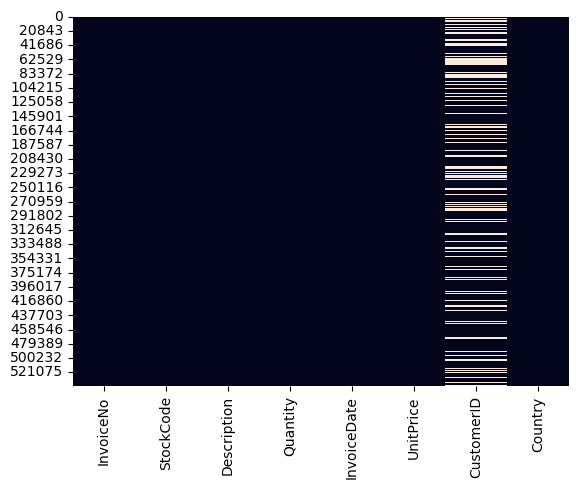

In [8]:
sns.heatmap(df.isnull(), cbar=False)

<AxesSubplot:title={'center':'Missing Data by Column'}>

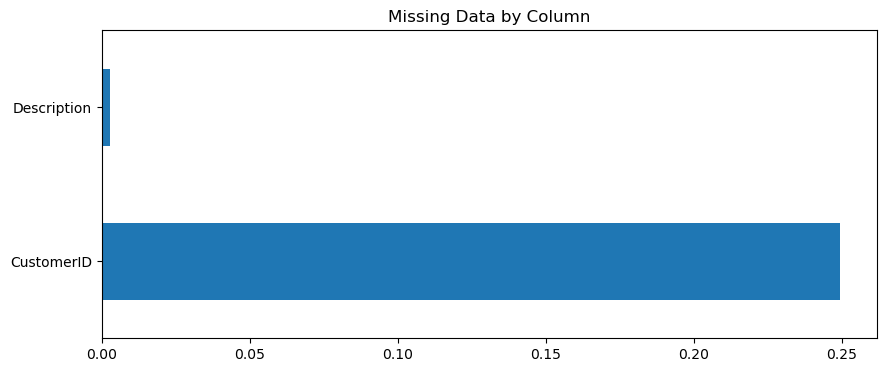

In [9]:
missing_pct = df.isnull().mean().sort_values(ascending=False)
missing_pct[missing_pct > 0].plot(kind='barh', figsize=(10, 4), title="Missing Data by Column")

/Users/jacquelinehardy/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Boxplot of Unit Price – Outlier Check')

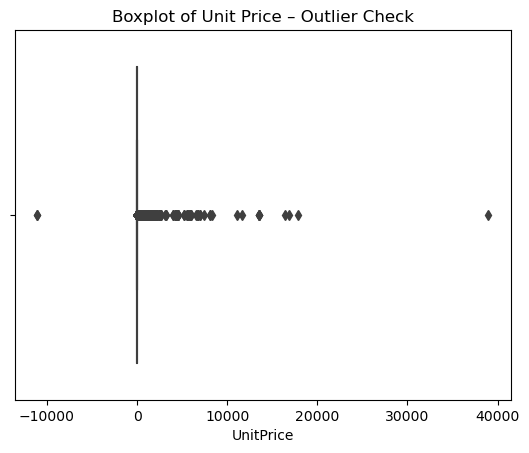

In [10]:
sns.boxplot(df['UnitPrice'])
plt.title("Boxplot of Unit Price – Outlier Check")

In [11]:
outliers = df[df['UnitPrice'] > 1000].sort_values(by='UnitPrice', ascending=False)
outliers[['InvoiceNo', 'Description', 'Quantity', 'UnitPrice', 'CustomerID']].head(5)

,InvoiceNo,Description,Quantity,UnitPrice,CustomerID
222681,C556445,Manual,-1,38970.00,15098.0
524602,C580605,AMAZON FEE,-1,17836.46,NaN
43702,C540117,AMAZON FEE,-1,16888.02,NaN
43703,C540118,AMAZON FEE,-1,16453.71,NaN
15016,C537630,AMAZON FEE,-1,13541.33,NaN


In [12]:
score = 100
score -= df['CustomerID'].isnull().mean() * 100
score -= df.duplicated().mean() * 50
score -= (df['Quantity'] < 0).mean() * 50
score = round(score, 1)

print(f"Data Quality Score: {score}/100")


Data Quality Score: 73.6/100


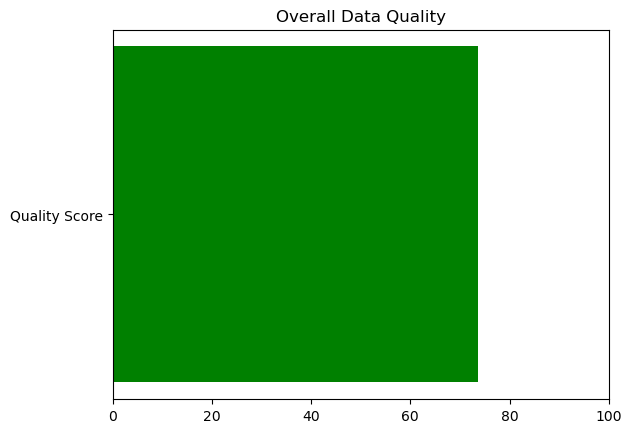

In [13]:
plt.barh(["Quality Score"], [score], color='green')
plt.xlim(0, 100)
plt.title("Overall Data Quality")
plt.show()

In [14]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [15]:
df['Country'].value_counts().head(10)

United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         2002
Portugal            1519
Australia           1259
Name: Country, dtype: int64

In [16]:
df['CustomerID'].nunique()

4372

<AxesSubplot:xlabel='Month'>

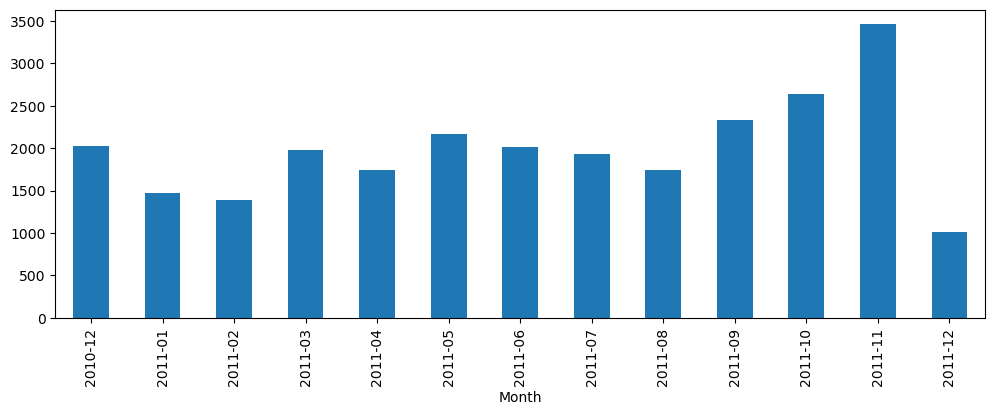

In [17]:
df['Month'] = df['InvoiceDate'].dt.to_period('M')
df.groupby('Month')['InvoiceNo'].nunique().plot(kind='bar', figsize=(12, 4))

## Cleaning Recommendations

- Remove or impute missing `CustomerID`s (depending on use case)
- Drop 5000+ exact duplicate records
- Remove negative quantities (returned items should be separate)
- Normalize country and product descriptions


In [18]:
df_clean = df.dropna(subset=['CustomerID'])
df_clean = df_clean[df_clean['Quantity'] >= 0]
df_clean = df_clean.drop_duplicates()

In [19]:
excluded_rows = df.shape[0] - df_clean.shape[0]
excluded_pct = round((excluded_rows / df.shape[0]) * 100, 2)
print(f"{excluded_rows} rows removed ({excluded_pct}% of original data).")

149177 rows removed (27.53% of original data).


In [20]:
df_clean['Total'] = df_clean['Quantity'] * df_clean['UnitPrice']

In [21]:
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (df_clean['InvoiceDate'].max() - x.max()).days,
    'InvoiceNo': 'nunique',
    'Total': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Total': 'Monetary'
})

rfm.describe()


,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000
mean,91.518322,4.271952,2048.215924
std,100.009747,7.705493,8984.248352
min,0.000000,1.000000,0.000000
25%,17.000000,1.000000,306.455000
50%,50.000000,2.000000,668.560000
75%,141.000000,5.000000,1660.315000
max,373.000000,210.000000,280206.020000


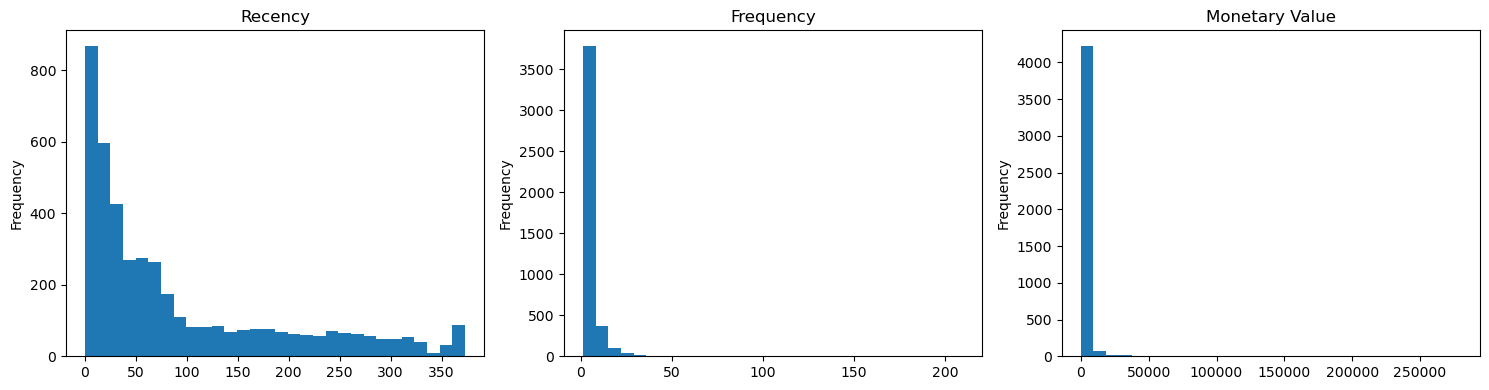

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
rfm['Recency'].plot(kind='hist', bins=30, ax=ax[0], title='Recency')
rfm['Frequency'].plot(kind='hist', bins=30, ax=ax[1], title='Frequency')
rfm['Monetary'].plot(kind='hist', bins=30, ax=ax[2], title='Monetary Value')
plt.tight_layout()
plt.show()

In [25]:
# Keep original for reference
rfm_original = rfm.copy()

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


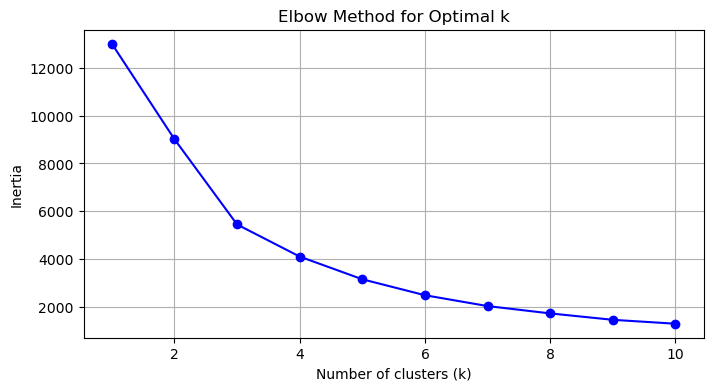

In [27]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []

# Try different values for k
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


In [30]:
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    print(f"Silhouette Score for k={k}: {round(score, 3)}")

Silhouette Score for k=2: 0.896
Silhouette Score for k=3: 0.594
Silhouette Score for k=4: 0.616
Silhouette Score for k=5: 0.616
Silhouette Score for k=6: 0.588
Silhouette Score for k=7: 0.519
Silhouette Score for k=8: 0.477
Silhouette Score for k=9: 0.478
Silhouette Score for k=10: 0.428


**Elbow Chart Insight**
- The “elbow” clearly appears at k = 3 or 4

- After 4, the inertia continues dropping — but the gain flattens, meaning additional clusters add little value

- This suggests k = 3 or 4 are both efficient choices

**Silhouette Scores**
- k = 2 has the highest score -> too simple
- k = 4 
    - Strong score
    - Clear elbow support from above 
    - Grouping as loyal/at risk/new/bargain
    

In [32]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Segment'] = kmeans.fit_predict(rfm_scaled)


In [39]:
rfm['Segment'] = kmeans.labels_

segment_summary = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Segment': 'count'
}).rename(columns={'Segment': 'Customer Count'})

segment_summary.style.background_gradient(cmap='Blues')

,Recency,Frequency,Monetary,Customer Count
Segment,,,,
0,42.692962,3.682160,1353.182227,3055
1,6.384615,82.692308,127187.959231,13
2,247.075914,1.552015,478.848773,1067
3,14.500000,22.333333,12690.500392,204


In [38]:
segment_labels = {
    0: "At Risk",
    1: "VIP",
    2: "Inactive",
    3: "Loyal"
}

rfm['SegmentLabel'] = rfm['Segment'].map(segment_labels)

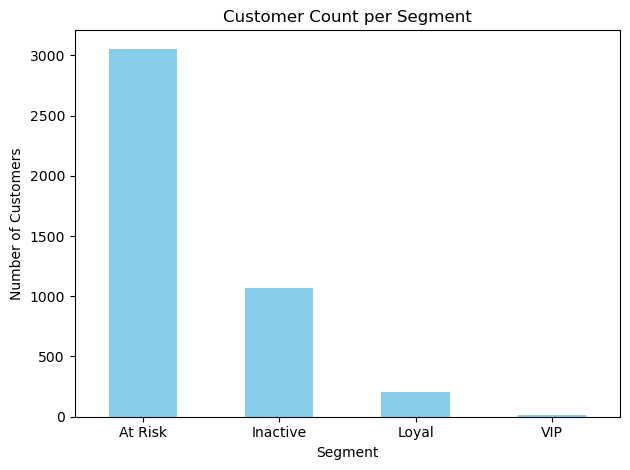

In [40]:
rfm['SegmentLabel'].value_counts().plot(kind='bar', color='skyblue', title="Customer Count per Segment")
plt.ylabel("Number of Customers")
plt.xlabel("Segment")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Segment Strategy Recommendations

| Segment   | Description                                                       | Strategy                                      |
|-----------|-------------------------------------------------------------------|-----------------------------------------------|
| **VIP**       | Extremely active, very frequent, high spend – your best customers | Offer exclusive perks, early access, VIP loyalty rewards |
| **Loyal**     | Active and high-spending, good frequency                      | Maintain engagement, surprise discounts, referral incentives |
| **At Risk**   | Large group, moderate value and frequency, not recent          | Send reactivation emails, win-back offers, ask for feedback |
| **Inactive**  | Long gone, low engagement, minimal contribution                | Suppress from active campaigns, retarget if they were once high-value |


In [ ]:
df_clean.to_csv("../data/crm_cleaned.csv", index=False)